In [43]:
import xgboost
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import warnings
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
#reduce sparsity using NMF
    #ref:https://www.kaggle.com/themissingsock/matrix-decomposition-with-buyer-data
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize

In [44]:
products  = pd.read_csv('../data/products.csv')
aisles = pd.read_csv('../data/aisles.csv')
departments = pd.read_csv('../data/departments.csv')
orders = pd.read_csv('../data/orders.csv')
order_products_prior = pd.read_csv('../data/order_products__prior.csv')
order_products_train =  pd.read_csv('../data/order_products__train.csv')
orders.fillna(value = 0, inplace = True)

In [154]:
print(order_products_train.groupby('order_id').count())
print(order_products_prior.groupby('order_id').count())
orders.info()

          product_id  add_to_cart_order  reordered
order_id                                          
1                  8                  8          8
36                 8                  8          8
38                 9                  9          9
96                 7                  7          7
98                49                 49         49
...              ...                ...        ...
3421049            6                  6          6
3421056            5                  5          5
3421058            8                  8          8
3421063            4                  4          4
3421070            3                  3          3

[131209 rows x 3 columns]
          product_id  add_to_cart_order  reordered
order_id                                          
2                  9                  9          9
3                  8                  8          8
4                 13                 13         13
5                 26                 26         26
6   

In [45]:
prior_train_data = pd.concat([order_products_prior, order_products_train]).sort_values(by=['order_id'])
prior_train_data = pd.merge(left = prior_train_data, right= products,
                             on = 'product_id').sort_values(by='order_id').reset_index(drop= True)
prior_train_data = pd.merge(left = prior_train_data, right = aisles,
                           left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)
prior_train_data = pd.merge(left = prior_train_data, right = departments,
                        left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)
prior_train_data = pd.merge(left = prior_train_data, right = orders,
                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)




In [144]:
orders.groupby('eval_set').nunique()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
eval_set,,,,,,
prior,3214874,206209,99,7,24,31
test,75000,75000,97,7,24,31
train,131209,131209,97,7,24,31


In [146]:
orders[orders['eval_set'] == ]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,0.0
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [4]:
order_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB


In [7]:
#order_products_train.info()

In [5]:
#prior_order = prior_order.sort_values(by=['order_id'])
##prior_order_data = pd.merge(left = order_products_prior, right= products,
 #                            on = 'product_id').sort_values(by='order_id').reset_index(drop= True)
#prior_order_data = pd.merge(left = prior_order_data , right = aisles ,
#                              on='aisle_id').sort_values(by='order_id').reset_index(drop= True)
#prior_order_data = pd.merge(left = prior_order_data, right = departments,
#                              on = 'department_id').sort_values(by='order_id').reset_index(drop= True)
#prior_order_data = pd.merge(left = prior_order_data, right = orders,
#                              on = 'order_id').sort_values(by='order_id').reset_index(drop= True)

In [93]:
prior_train_data.groupby('eval_set').nunique()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
eval_set,,,,,,,,,,,,,,
prior,3214874,49677,145,2,49677,134,21,134,21,206209,99,7,24,31
train,131209,39123,80,2,39123,134,21,134,21,131209,97,7,24,31


In [9]:
#train_order_data.groupby('eval_set').nunique()

In [14]:
#test_order = train_order.sort_values(by=['order_id'])
#test_order_data = orders[orders['eval_set'] == 'test']


In [10]:
#test_order_data.groupby('eval_set').nunique()

In [11]:
prior_train_data['days_since_prior_order'] = prior_train_data['days_since_prior_order'].astype(int)

In [12]:
prior_train_data.dtypes

order_id                   int64
product_id                 int64
add_to_cart_order          int64
reordered                  int64
product_name              object
aisle_id                   int64
department_id              int64
aisle                     object
department                object
user_id                    int64
eval_set                  object
order_number               int64
order_dow                  int64
order_hour_of_day          int64
days_since_prior_order     int32
dtype: object

#### In the absence of the RFM for analysis, we need to engineer some features that would be useful.
We can start with customer behavior
  - total number of orders
  - mean lag between orders
  - mean number of products per order
  - meadian hour of order
  - rate of peak-day ordering
  - rate of peak-time ordering

In [46]:
product_counts = prior_train_data.groupby('order_id')['product_id'].count().reset_index(name='num_products').set_index('order_id')


In [15]:
product_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3346083 entries, 1 to 3421083
Data columns (total 1 columns):
 #   Column        Dtype
---  ------        -----
 0   num_products  int64
dtypes: int64(1)
memory usage: 51.1 MB


In [47]:
#caculating number of orders per customer
features = pd.merge(product_counts,orders, on= 'order_id', how='inner')


In [17]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3346083 entries, 0 to 3346082
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   num_products            int64  
 2   user_id                 int64  
 3   eval_set                object 
 4   order_number            int64  
 5   order_dow               int64  
 6   order_hour_of_day       int64  
 7   days_since_prior_order  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 204.2+ MB


In [18]:
#features_train_set.info()

In [48]:
orders_counts = features.groupby('user_id')['order_number'].max().reset_index(name='num_orders').set_index('user_id')


In [20]:
orders_counts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206209 entries, 1 to 206209
Data columns (total 1 columns):
 #   Column      Non-Null Count   Dtype
---  ------      --------------   -----
 0   num_orders  206209 non-null  int64
dtypes: int64(1)
memory usage: 3.1 MB


In [126]:
#features_train_set.info()

In [127]:
#features_train_set.nunique()

In [128]:
#train_orders_counts.num_orders

In [23]:
features[features['user_id'] == 1].head(5)

,order_id,num_products,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
422026,431534,8,1,prior,5,4,15,28.0
463310,473747,5,1,prior,3,3,12,21.0
537962,550135,5,1,prior,7,1,9,20.0
1161799,1187899,11,1,train,11,4,8,14.0
2205292,2254736,5,1,prior,4,4,7,29.0


In [49]:
#creating boolean column to record whether order occured on peak day i.e Sunday
# Assumption is that 0 to be Sunday, 1 Monday and so on. As per EDA Sunday and Monday had peak orders
features['order_on_peak'] = np.where(features['order_dow'] <= 1, 1, 0)
features['peak_time'] = np.where((features['order_hour_of_day'] >= 10) & (features['order_hour_of_day'] <= 16) , 1, 0)

In [50]:
# Calculate the rate of peak day ordering per Customer 
peakday_rate = round(features.groupby('user_id')['order_on_peak'].mean(),2)

#Calculate  average hour of ay at which customer placed an order
median_hour = round(features.groupby('user_id')['order_hour_of_day'].median(),0)

#Calculate boolean value for peak time. Peak time is derived during EDA 10 to 16
peaktime_rate = round(features.groupby('user_id')['peak_time'].mean(),2)

#Average lag between  orders per customer
mean_lag = round(features.groupby('user_id')['days_since_prior_order'].mean(),2)

#mean number of products ordered per customer
mean_products = round(features.groupby('user_id')['num_products'].mean(),2)

In [74]:
#Create feature set with all customer feature built
features = pd.concat([orders_counts,peakday_rate,median_hour,peaktime_rate,mean_lag,mean_products],axis = 1)#.reset_index()
#features = features.set_index('user_id')
features.columns = ['num_orders','peakday_rate','median_hour','peaktime_rate','mean_lag','mean_products']
features.head(3)

,num_orders,peakday_rate,median_hour,peaktime_rate,mean_lag,mean_products
user_id,,,,,,
1,11,0.27,8.0,0.36,17.27,6.36
2,15,0.40,10.0,0.80,15.20,15.07
3,12,0.67,16.0,0.58,11.08,7.33


In [75]:
features_org = features

In [138]:
#features_train_set.info()

In [29]:
features.info()
features.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 206209 entries, 1 to 206209
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_orders     206209 non-null  int64  
 1   peakday_rate   206209 non-null  float64
 2   median_hour    206209 non-null  float64
 3   peaktime_rate  206209 non-null  float64
 4   mean_lag       206209 non-null  float64
 5   mean_products  206209 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 11.0 MB


num_orders       0
peakday_rate     0
median_hour      0
peaktime_rate    0
mean_lag         0
mean_products    0
dtype: int64

In [140]:
#features_test_set.info()

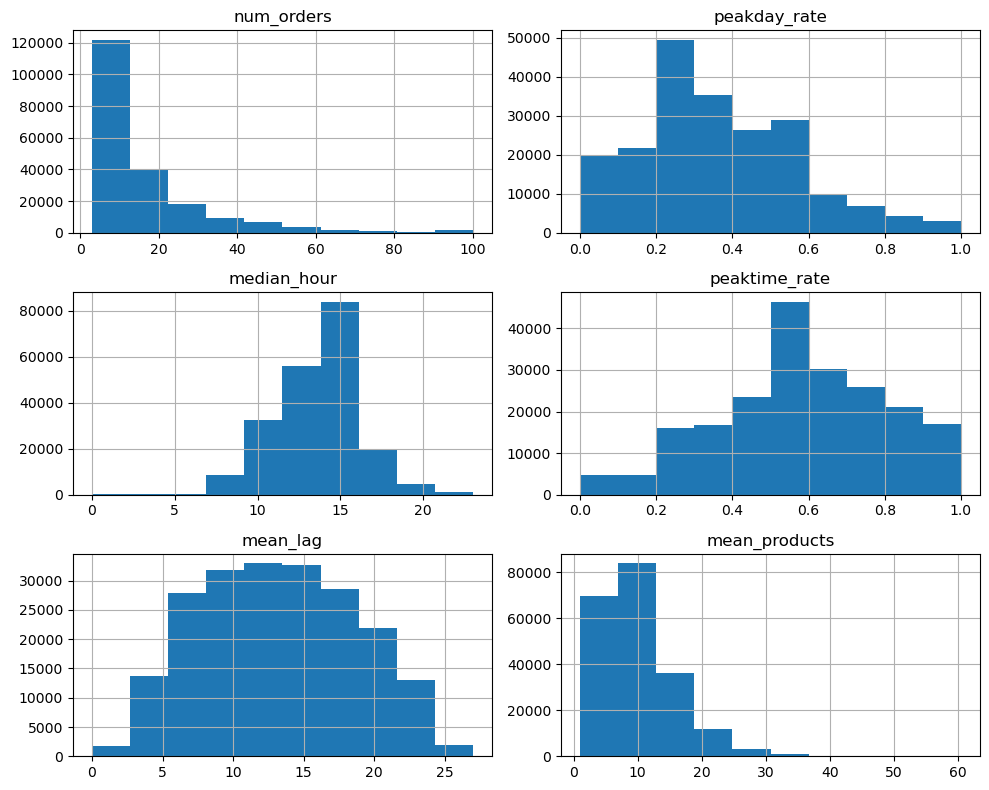

In [53]:
features.hist(figsize=(10,8))
plt.tight_layout()

In [142]:
features.describe()

,num_orders,peakday_rate,median_hour,peaktime_rate,mean_lag,mean_products
count,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000,206209.000000
mean,15.590367,0.354627,13.590740,0.578720,12.804741,9.951583
std,16.654774,0.218951,2.647454,0.236458,5.376146,5.863574
min,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,5.000000,0.210000,12.000000,0.410000,8.500000,5.740000
50%,9.000000,0.330000,14.000000,0.600000,12.610000,8.930000
75%,19.000000,0.500000,15.000000,0.750000,17.000000,13.000000
max,99.000000,1.000000,23.000000,1.000000,26.910000,70.250000


CPU times: total: 422 ms
Wall time: 422 ms


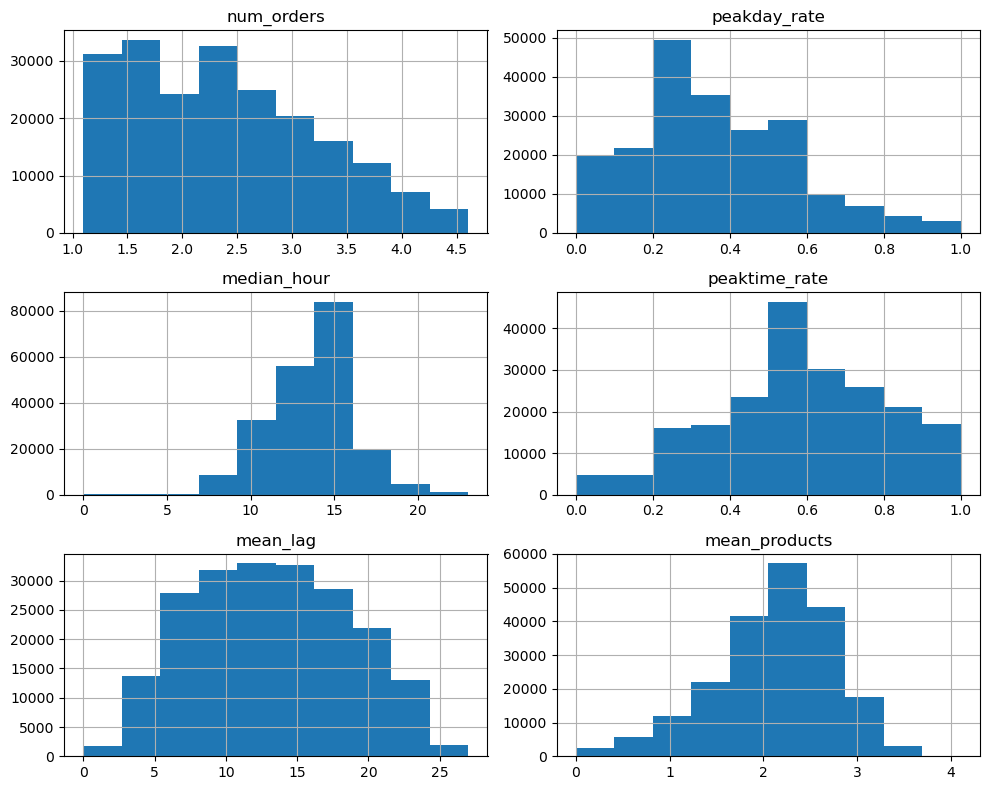

In [54]:
%%time
# Logarithmic transformations operate to compress the larger numbers and relatively expand the smaller numbers. This, in turn, results in less skewed values, especially in the case of heavy-tailed distributions. Other variable transformations used include Square root and Box-Cox transformations, which generalize the former two.

features['num_orders'] = np.log(features['num_orders'])
features['mean_products'] = np.log(features['mean_products'])
features.hist(figsize=(10,8))
plt.tight_layout()

In [55]:
#features have different scales, K-Means might prioritize the features with larger scales. 
#In such cases, it's often a good practice to scale your features to have a mean of 0 and a
#standard deviation of 1 (z-score normalization). 
scaler = StandardScaler()
selected_columns = ['num_orders','peakday_rate','median_hour','peaktime_rate','mean_lag','mean_products']
selected_features = features[selected_columns]
feature_scaled = scaler.fit_transform(selected_features)

In [72]:
features.head(3)

,num_orders,peakday_rate,median_hour,peaktime_rate,mean_lag,mean_products
user_id,,,,,,
1,2.397895,0.27,8.0,0.36,17.27,1.850028
2,2.708050,0.40,10.0,0.80,15.20,2.712706
3,2.484907,0.67,16.0,0.58,11.08,1.991976


In [113]:
feature_scaled

array([[-0.31368362, -0.40118315, -2.15903305, -0.95389857,  0.74513572,
        -0.62054891],
       [-0.07361924,  0.21282914, -1.3865816 ,  0.96700651,  0.36603953,
         0.87067423],
       [-0.25366752,  1.48808544,  0.93077273,  0.00655397, -0.38849009,
        -0.45447699],
       ...,
       [-0.01360315,  0.11836571, -0.61413016,  0.1811817 ,  0.0437162 ,
         0.677209  ],
       [ 1.96692792, -0.21225629,  0.54454701,  0.48678024, -1.08258409,
         0.65666402],
       [-0.13363534, -0.30671972,  0.15832129,  0.92334958,  0.72132775,
        -0.0333049 ]])

In [110]:
feature_scaled = pd.DataFrame(feature_scaled)

feature_scaled.describe()

,0,1,2,3,4,5
count,2.062090e+05,2.062090e+05,2.062090e+05,2.062090e+05,2.062090e+05,2.062090e+05
mean,-8.145731e-17,3.901957e-16,-1.086442e-16,5.436690e-16,-6.621680e-16,-3.418519e-16
std,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,-7.938124e-01,-1.676439e+00,-5.248839e+00,-2.525548e+00,-2.417662e+00,-1.538225e+00
25%,-6.137641e-01,-6.845734e-01,-6.141302e-01,-6.483000e-01,-8.060453e-01,-7.198496e-01
50%,-3.736997e-01,-1.177929e-01,1.583213e-01,5.021090e-02,-2.953911e-02,-1.685593e-01
75%,2.264612e-01,6.851463e-01,5.445470e-01,7.487218e-01,7.744378e-01,5.162733e-01
max,5.027749e+00,3.046732e+00,3.634353e+00,1.840145e+00,2.527071e+00,8.648661e+00


In [33]:
feature_scaled.isna().sum()

0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

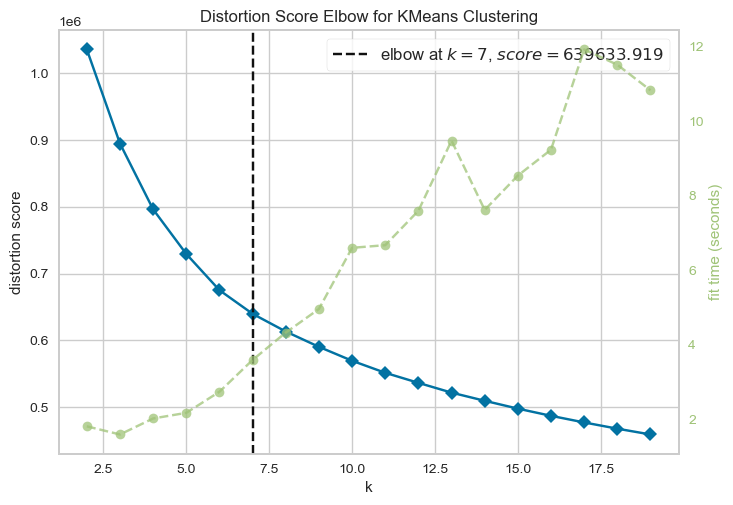

CPU times: total: 9min 10s
Wall time: 1min 55s


In [149]:
%%time 
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,20))

visualizer.fit(feature_scaled)   
visualizer.show();

C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


CPU times: total: 15.8 s
Wall time: 2.73 s


Text(0.5, 1.0, 'Clustering using K-Means Algorithm')

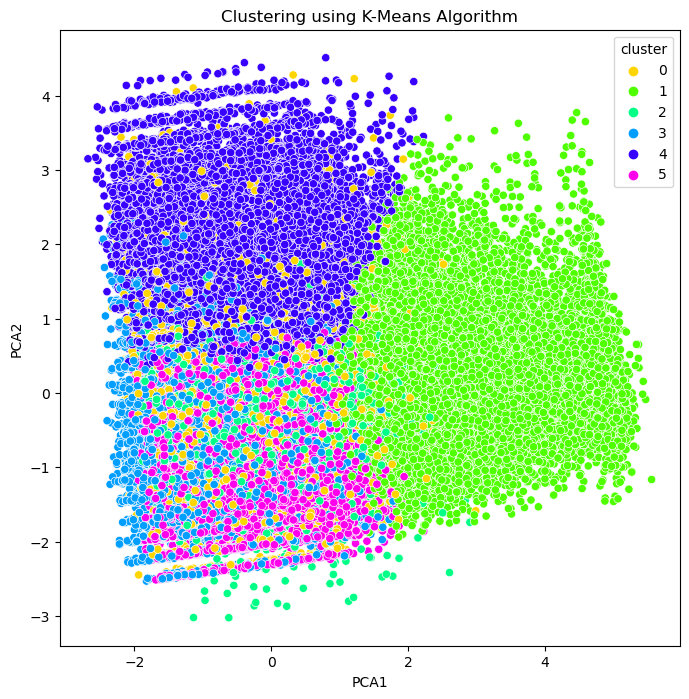

In [172]:
%%time
# using the k = 7 as recommended by KElbowVisualizer

# Create a K-Means clusterer with the chosen number of clusters
kmeans = KMeans(n_clusters=6 , random_state=0)

# Fit the K-Means clusterer to your scaled features
clusterer = kmeans.fit(feature_scaled)

# Get the cluster assignments for each data point
cluster_labels = clusterer.labels_
#feature_scaled['Cluster'] = cluster_labels

pca = PCA(n_components = 2)
principal_components = pca.fit_transform(feature_scaled)
pca_df = pd.DataFrame(data = principal_components, columns=['PCA1','PCA2'])

pca_df_kmeans = pd.concat([pca_df,pd.DataFrame({'cluster' : cluster_labels})],axis = 1)


plt.figure(figsize =(8,8))

# Create a custom color palette based on the number of clusters
cluster_palette = sns.color_palette("hsv", 6)

ax = sns.scatterplot(x = 'PCA1',y='PCA2',hue='cluster', data = pca_df_kmeans,palette=cluster_palette)
plt.title("Clustering using K-Means Algorithm")


C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Pallavi\AppData\Local\Temp\ipykernel_4620\758346889.py:25: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  ax = sns.scatterplot(x = 'PCA1',y='PCA2',hue='cluster', data = pca_df_kmeans,palette=cluster_palette)


Text(0.5, 1.0, 'Clustering using K-Means Algorithm')

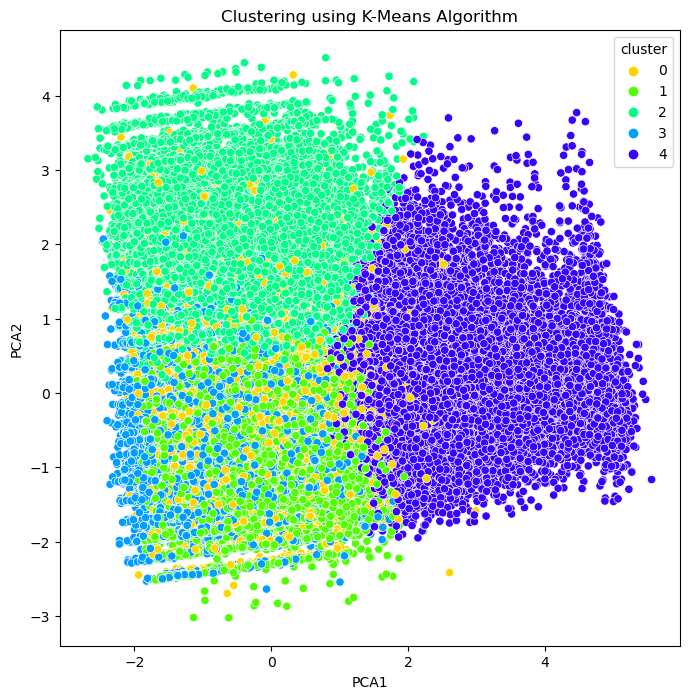

In [176]:
# using the k = 7 as recommended by KElbowVisualizer

# Create a K-Means clusterer with the chosen number of clusters
kmeans = KMeans(n_clusters=5 , random_state=0)

# Fit the K-Means clusterer to your scaled features
clusterer = kmeans.fit(feature_scaled)

# Get the cluster assignments for each data point
cluster_labels = clusterer.labels_
#feature_scaled['Cluster'] = cluster_labels

pca = PCA(n_components = 2)
principal_components = pca.fit_transform(feature_scaled)
pca_df = pd.DataFrame(data = principal_components, columns=['PCA1','PCA2'])

pca_df_kmeans = pd.concat([pca_df,pd.DataFrame({'cluster' : cluster_labels})],axis = 1)


plt.figure(figsize =(8,8))

# Create a custom color palette based on the number of clusters
cluster_palette = sns.color_palette("hsv", 6)

ax = sns.scatterplot(x = 'PCA1',y='PCA2',hue='cluster', data = pca_df_kmeans,palette=cluster_palette)
plt.title("Clustering using K-Means Algorithm")


In [ ]:
%%time
from sklearn.manifold import TSNE
#fit_predict method to both fit the K-Means clusterer and obtain the cluster assignments 
#for each data point. However, the fit_predict method is used to fit the model and directly return the cluster labels. It does not return a clusterer object.

# Set a random seed for reproducibility
random_seed = 42

# Create a K-Means clusterer with the chosen number of clusters
kmeans = KMeans(n_clusters=3, random_state=random_seed)

# Fit the K-Means clusterer to your scaled features
#clusterer = kmeans.fit(feature_scaled)

# Get the cluster assignments for each data point

cluster_labels = kmeans.fit_predict(feature_scaled)
#feature_scaled['Cluster'] = cluster_labels

feature_scaled_df = pd.DataFrame(feature_scaled)
df_new = feature_scaled_df.assign(Cluster = cluster_labels)


model = TSNE(random_state = 1)

transformed = model.fit_transform(feature_scaled_df)

plt.title('Flattened Graph of{}  clusters'.format(3))
sns.scatterplot(x = transformed[:,0], y = transformed [:,1],
                 hue = cluster_labels, style = cluster_labels, palette = "Set1")


<Axes: >

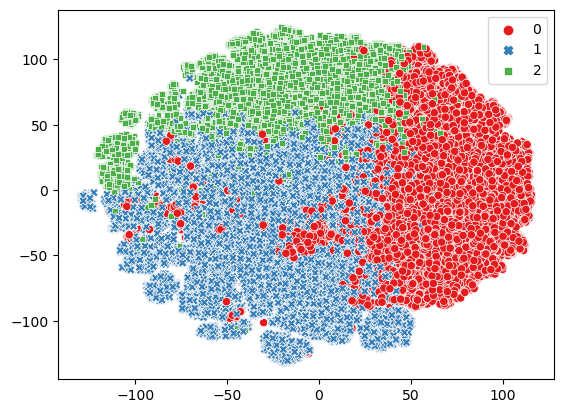

In [118]:
sns.scatterplot(x = transformed[:,0], y = transformed [:,1],
                 hue = cluster_labels, style = cluster_labels, palette = "Set1")

In [107]:
#Dimension Reduction

pca = PCA(n_components = 4)
principal_components = pca.fit_transform(feature_scaled)
pca_df = pd.DataFrame(data = principal_components, columns=['PCA1','PCA2','PC3','PC4'])
pca_df['Cluster'] = cluster_labels
#pca_df_kmeans = pd.concat([pca_df,pd.DataFrame({'cluster' : cluster_labels})],axis = 1)


Text(0, 0.5, 'variance %')

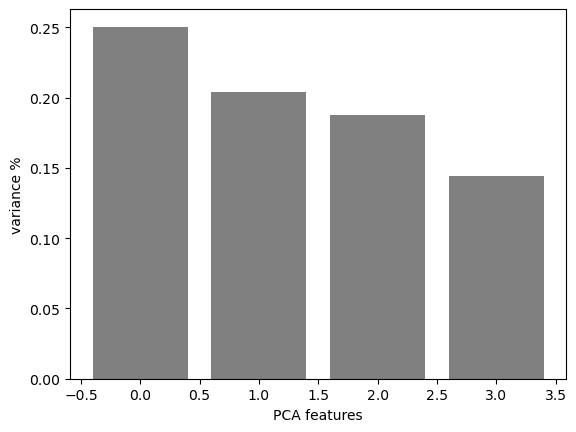

In [108]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='grey')
plt.xlabel('PCA features')
plt.ylabel('variance %')

<timed exec>:6: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.


CPU times: total: 1.23 s
Wall time: 1.82 s


Text(0.5, 1.0, 'Clustering using K-Means Algorithm')

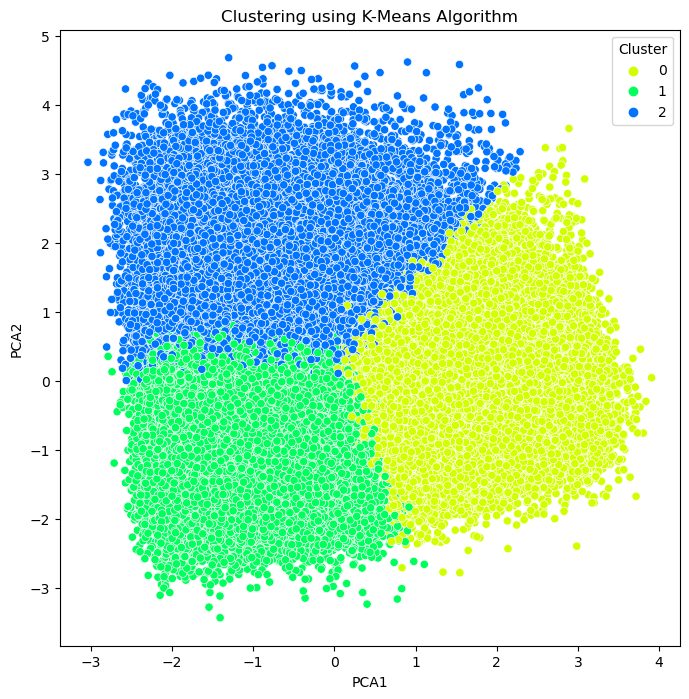

In [109]:
%%time
# Create a custom color palette based on the number of clusters
cluster_palette = sns.color_palette("hsv", 4)


plt.figure(figsize =(8,8))
ax = sns.scatterplot(x = 'PCA1',y='PCA2',hue='Cluster', data = pca_df,palette=cluster_palette)
plt.title("Clustering using K-Means Algorithm")

In [76]:
# Lets do reverse engineering... from the scaled data lets inverse to original data
# so that we can use original format or scale for better interpretation
#cluster_centers = pd.DataFrame(data = clusterer.cluster_centers_)#,columns = [features.columns])
cluster_centers_org = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_info = pd.DataFrame(cluster_centers_org, columns=features.columns)
#cluster_info['Cluster'] = range(len(cluster_info ))
#org_features = scaler.inverse_transform(feature_scaled)

index_start = 1
labels  = pd.DataFrame({'Cluster': kmeans.labels_})
labels.index = range(index_start, index_start + len(kmeans.labels_))
original_data_with_clusters = pd.concat([features_org, labels], axis=1)
original_data_with_clusters.index.name = 'user_id'

print(cluster_centers_info)



   num_orders  peakday_rate  median_hour  peaktime_rate   mean_lag  \
0    3.253766      0.341133    12.889608       0.582253   8.505101   
1    1.928860      0.365033    12.550004       0.692817  16.175508   
2    2.068386      0.356116    16.710334       0.347359  14.507040   

   mean_products  
0       2.205658  
1       2.045553  
2       2.136096  


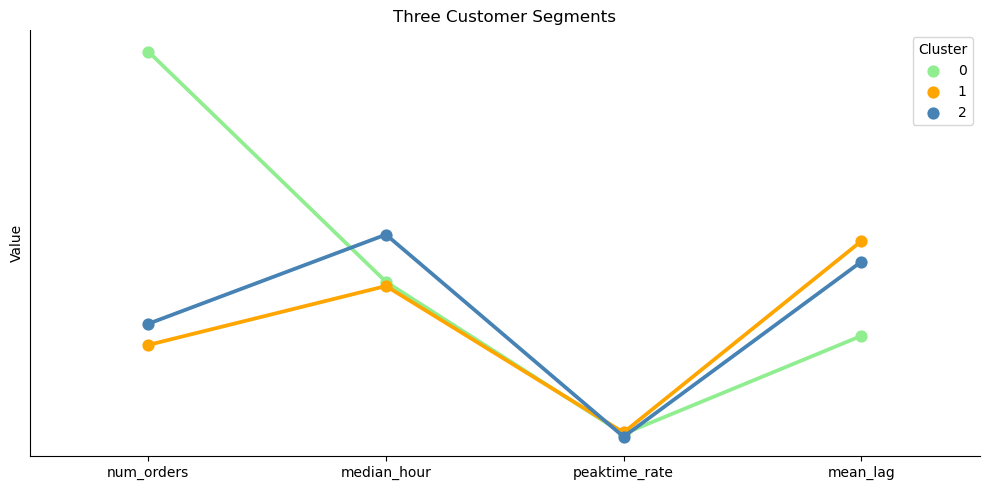

In [119]:
""" Let's visualize how different customer segments as per clusters ib various metrics
(attributes) with the dataset. """
cluster_melt = pd.melt(original_data_with_clusters.reset_index(),
                       id_vars=['user_id', 'Cluster'],
                       value_vars=['num_orders', 
                                  # 'peakday_rate',
                                   'median_hour',
                                   'peaktime_rate',
                                   'mean_lag', 
                                  # 'mean_products'
                                  ],
                       var_name='Metric',
                       value_name='Value')
# Create snake plot
palette = ['lightgreen', 'orange', 'steelblue']#,'black','purple','green']
plt.figure(figsize=(10,5))
sns.pointplot(x='Metric', y='Value', data=cluster_melt, hue='Cluster', 
              palette=palette)
plt.xlabel('')
plt.ylabel('Value')
plt.yticks([])
plt.title('Three Customer Segments')
sns.despine()
plt.tight_layout()
plt.savefig('snake_plot.png', dpi=300, pad_inches=2.0)
plt.show();

<Axes: xlabel='Cluster', ylabel='count'>

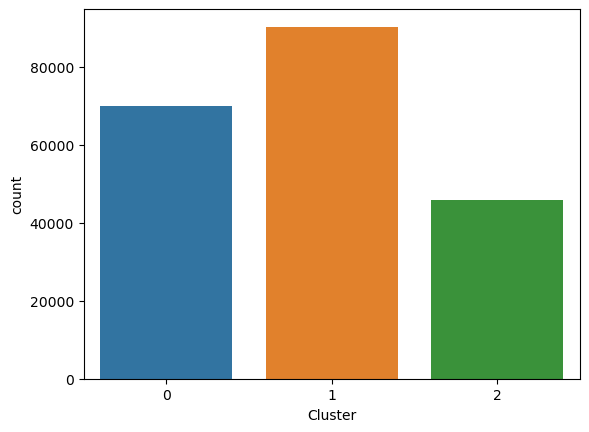

In [62]:
# our biggest customer is in cluster 1 !!!
# Centroid details of cluster 1 :
# num_orders  10.08107766
# peakday_rate   0.35961307
# median_hour 12.44081171
# peaktime_rate   0.67501309
# mean_lag 14.59971301 
# mean_products 9.91167917

sns.countplot(x ='Cluster', data= original_data_with_clusters)

In [92]:
# lets analyse each cluster Segment
print('---------------- Cluster 0 features ----------------\n')
print('Average Orders', round(original_data_with_clusters[original_data_with_clusters['Cluster'] == 0]['num_orders'].mean()))
print#('Average Orders', original_data_with_clusters[original_data_with_clusters['Cluster'] == 0]['num_orders'].mean())
print('---------------- ------------------ ----------------\n')
print('---------------- Cluster 1 features ----------------\n')
print('Average Orders',round(original_data_with_clusters[original_data_with_clusters['Cluster'] == 1]['num_orders'].mean()))
print('---------------- ------------------ ----------------\n')
print('---------------- Cluster 2features ----------------\n')
print('Average Orders',round(original_data_with_clusters[original_data_with_clusters['Cluster'] == 2]['num_orders'].mean()))
print('---------------- ------------------ ----------------\n')

---------------- Cluster 0 features ----------------

Average Orders 32
---------------- ------------------ ----------------

---------------- Cluster 1 features ----------------

Average Orders 8
---------------- ------------------ ----------------

---------------- Cluster 2features ----------------

Average Orders 9
---------------- ------------------ ----------------



In [121]:
#median_hour = round(features.groupby('user_id')['order_hour_of_day'].median(),0)
subset = prior_train_data[prior_train_data['user_id'].isin(original_data_with_clusters[original_data_with_clusters['Cluster'] == 1].index)]
median_order_hour = subset['order_hour_of_day'].median()
#.groupby('user_id')['order_hour_of_day'].median()
print("Median order hour for the selected users in Cluster 1:", median_order_hour)

Median order hour for the selected users in Cluster 1: 13.0


In [122]:
#median_hour = round(features.groupby('user_id')['order_hour_of_day'].median(),0)
subset = prior_train_data[prior_train_data['user_id'].isin(original_data_with_clusters[original_data_with_clusters['Cluster'] == 0].index)]
median_order_hour = subset['order_hour_of_day'].median()
#.groupby('user_id')['order_hour_of_day'].median()
print("Median order hour for the selected users in Cluster 0:", median_order_hour)

Median order hour for the selected users in Cluster 0: 13.0


In [123]:
#median_hour = round(features.groupby('user_id')['order_hour_of_day'].median(),0)
subset = prior_train_data[prior_train_data['user_id'].isin(original_data_with_clusters[original_data_with_clusters['Cluster'] == 2].index)]
median_order_hour = subset['order_hour_of_day'].median()
#.groupby('user_id')['order_hour_of_day'].median()
print("Median order hour for the selected users in Cluster 2:", median_order_hour)

Median order hour for the selected users in Cluster 2: 17.0


In [124]:
#mean_lag = round(features.groupby('user_id')['days_since_prior_order'].mean(),2)

subset = prior_train_data[prior_train_data['user_id'].isin(original_data_with_clusters[original_data_with_clusters['Cluster'] == 0].index)]
median_order_hour = subset['days_since_prior_order'].median()
#.groupby('user_id')['order_hour_of_day'].median()
print("days_since_prior_order for the selected users in Cluster 0:", median_order_hour)

#median_hour = round(features.groupby('user_id')['order_hour_of_day'].median(),0)
subset = prior_train_data[prior_train_data['user_id'].isin(original_data_with_clusters[original_data_with_clusters['Cluster'] == 1].index)]
median_order_hour = subset['days_since_prior_order'].median()
#.groupby('user_id')['order_hour_of_day'].median()
print("days_since_prior_order for the selected users in Cluster 1:", median_order_hour)

#median_hour = round(features.groupby('user_id')['order_hour_of_day'].median(),0)
subset = prior_train_data[prior_train_data['user_id'].isin(original_data_with_clusters[original_data_with_clusters['Cluster'] == 2].index)]
median_order_hour = subset['days_since_prior_order'].median()
#.groupby('user_id')['order_hour_of_day'].median()
print("days_since_prior_order for the selected users in Cluster 2:", median_order_hour)

days_since_prior_order for the selected users in Cluster 0: 7.0
days_since_prior_order for the selected users in Cluster 1: 16.0
days_since_prior_order for the selected users in Cluster 2: 12.0


In [100]:
prior_train_data[prior_train_data['user_id'].isin(original_data_with_clusters[original_data_with_clusters['Cluster'] == 1].index)]\
                            .groupby('product_name')['product_name'].count().reset_index(name = 'product_cnt')\
                            .sort_values(by = 'product_cnt',ascending = False).head(10)

,product_name,product_cnt
3510,Banana,91133
3310,Bag of Organic Bananas,62581
27434,Organic Baby Spinach,48463
30419,Organic Strawberries,44051
27398,Organic Avocado,39042
21323,Large Lemon,34788
28841,Organic Hass Avocado,33132
40916,Strawberries,31371
22278,Limes,28924
11080,Cucumber Kirby,22261


In [101]:
prior_train_data[prior_train_data['user_id'].isin(original_data_with_clusters[original_data_with_clusters['Cluster'] == 0].index)]\
                            .groupby('product_name')['product_name'].count().reset_index(name = 'product_cnt')\
                            .sort_values(by = 'product_cnt',ascending = False).head(10)

,product_name,product_cnt
3648,Banana,336489
3444,Bag of Organic Bananas,289443
31665,Organic Strawberries,202082
28603,Organic Baby Spinach,171882
30053,Organic Hass Avocado,164332
28567,Organic Avocado,120191
31112,Organic Raspberries,108154
32221,Organic Whole Milk,107535
22225,Large Lemon,105114
23225,Limes,99595


In [102]:
prior_train_data[prior_train_data['user_id'].isin(original_data_with_clusters[original_data_with_clusters['Cluster'] == 2].index)]\
                            .groupby('product_name')['product_name'].count().reset_index(name = 'product_cnt')\
                            .sort_values(by = 'product_cnt',ascending = False).head(10)

,product_name,product_cnt
3322,Banana,63669
3131,Bag of Organic Bananas,42906
26287,Organic Baby Spinach,31360
29193,Organic Strawberries,29444
26252,Organic Avocado,24991
27645,Organic Hass Avocado,23413
20388,Large Lemon,20890
39292,Strawberries,19288
21323,Limes,18141
28664,Organic Raspberries,14933


In [ ]:
prior_train_data[prior_train_data['user_id'].isin(original_data_with_clusters[original_data_with_clusters['Cluster'] == 1].index)]\
                            .groupby('order_dow')['product_name'].count().reset_index(name = 'product_cnt')\
                            .sort_values(by = 'product_cnt',ascending = False).head(10)

In [90]:
cluster_0_avg_orders = original_data_with_clusters[original_data_with_clusters['Cluster'] == 0]['num_orders'].mean()
print(f'Average Orders: {cluster_0_avg_orders:.2f} ({cluster_0_avg_orders/original_data_with_clusters["num_orders"].mean():.2%})')

Average Orders: 31.52 (194.27%)


In [89]:
original_data_with_clusters[original_data_with_clusters['Cluster'] == 0].info()
original_data_with_clusters[original_data_with_clusters['Cluster'] == 1].info()
original_data_with_clusters[original_data_with_clusters['Cluster'] == 2].info()

<class 'pandas.core.frame.DataFrame'>
Index: 70038 entries, 7 to 206208
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_orders     70038 non-null  int64  
 1   peakday_rate   70038 non-null  float64
 2   median_hour    70038 non-null  float64
 3   peaktime_rate  70038 non-null  float64
 4   mean_lag       70038 non-null  float64
 5   mean_products  70038 non-null  float64
 6   Cluster        70038 non-null  int32  
dtypes: float64(5), int32(1), int64(1)
memory usage: 4.0 MB
<class 'pandas.core.frame.DataFrame'>
Index: 90365 entries, 1 to 206209
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num_orders     90365 non-null  int64  
 1   peakday_rate   90365 non-null  float64
 2   median_hour    90365 non-null  float64
 3   peaktime_rate  90365 non-null  float64
 4   mean_lag       90365 non-null  float64
 5   mean_products  90365 no

### Feature Engineeing
#### RFM

In the given data  no ordered date is specified but days since prior order is given, which can be used  
Frequency : Mean lag between orders 
Monetary value :  no price/cost is provided in the data set. As an alternative we can use mean  number of products per order

#### Customer Segmentation Method # 2

In [3]:
products['organic'] = products['product_name'].apply(lambda x: 'organic' in x.lower()).astype(int)
products['gluten'] = products['product_name'].apply(lambda x: 'gluten' in x.lower()).astype(int)
products['vegetarian'] = products['product_name'].apply(lambda x: 'vegetarian' in x.lower()).astype(int)
products['dairy free'] = products['product_name'].apply(lambda x: 'dairy free' in x.lower()).astype(int)
products['vegan'] = products['product_name'].apply(lambda x: 'dairy free' in x.lower()).astype(int)


In [196]:
import gc
gc.collect()

2454

In [4]:
prior__data = pd.concat([order_products_prior, order_products_train]).sort_values(by=['order_id'])
prior__data = pd.merge(left = prior__data, right= products,
                             on = 'product_id').sort_values(by='order_id').reset_index(drop= True)
prior__data = pd.merge(left = prior__data, right = aisles,
                           left_on='aisle_id', right_on='aisle_id').sort_values(by=['order_id']).reset_index(drop=True)
prior__data = pd.merge(left = prior__data, right = departments,
                        left_on='department_id', right_on='department_id').sort_values(by=['order_id']).reset_index(drop=True)
prior__data = pd.merge(left = prior__data, right = orders,
                             left_on='order_id', right_on='order_id').sort_values(by=['order_id']).reset_index(drop=True)

In [5]:
# Working M part
#quantity = prior_orders_data.groupby('order_id').size().reset_index(name='product_cnt')
#full_orders = pd.merge(orders,quantity,  how ='left', on = 'order_id')
quantity_items = prior__data.groupby('user_id')['product_id'].count().reset_index(name='quantity')
# R part

user_transaction = prior__data.groupby('user_id')['days_since_prior_order'].mean().reset_index(name = 'recency')

# F part 

user_fpart = prior__data.groupby('user_id')['order_number'].max().reset_index()
user_fpart.rename(columns={'order_number': 'frequency'}, inplace=True)



In [157]:
merge1 = pd.merge(quantity_items, user_transaction, on = 'user_id' ,how ='left')
users =  pd.merge(merge1,user_fpart, on  = 'user_id', how = 'left')
users.head(5)


,user_id,quantity,recency,frequency
0,1,70,17.828571,11
1,2,226,16.973451,15
2,3,88,10.181818,12
3,4,18,11.944444,5
4,5,46,9.369565,5


In [149]:
users.set_index(users.index + 1, inplace=True)

In [176]:
users.head(5)

,user_id,quantity,recency,frequency,recency_score,frequency_score,quantity_score,organic_perf,gluten_perf,vegetarian_perf,dairy_perf,vegan_perf
0,1,70,17.828571,11,2,3,3,0.257143,0.000000,0.0,0.0,0.0
1,2,226,16.973451,15,2,4,4,0.247788,0.030973,0.0,0.0,0.0
2,3,88,10.181818,12,4,3,3,0.340909,0.022727,0.0,0.0,0.0
3,4,18,11.944444,5,3,1,1,0.111111,0.000000,0.0,0.0,0.0
4,5,46,9.369565,5,4,1,2,0.500000,0.021739,0.0,0.0,0.0


C:\Users\Pallavi\AppData\Local\Temp\ipykernel_18164\401480841.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(users['frequency'],ax =ax[0,0])
C:\Users\Pallavi\AppData\Local\Temp\ipykernel_18164\401480841.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(users['quantity'],ax =ax[0,1])
C:\Us

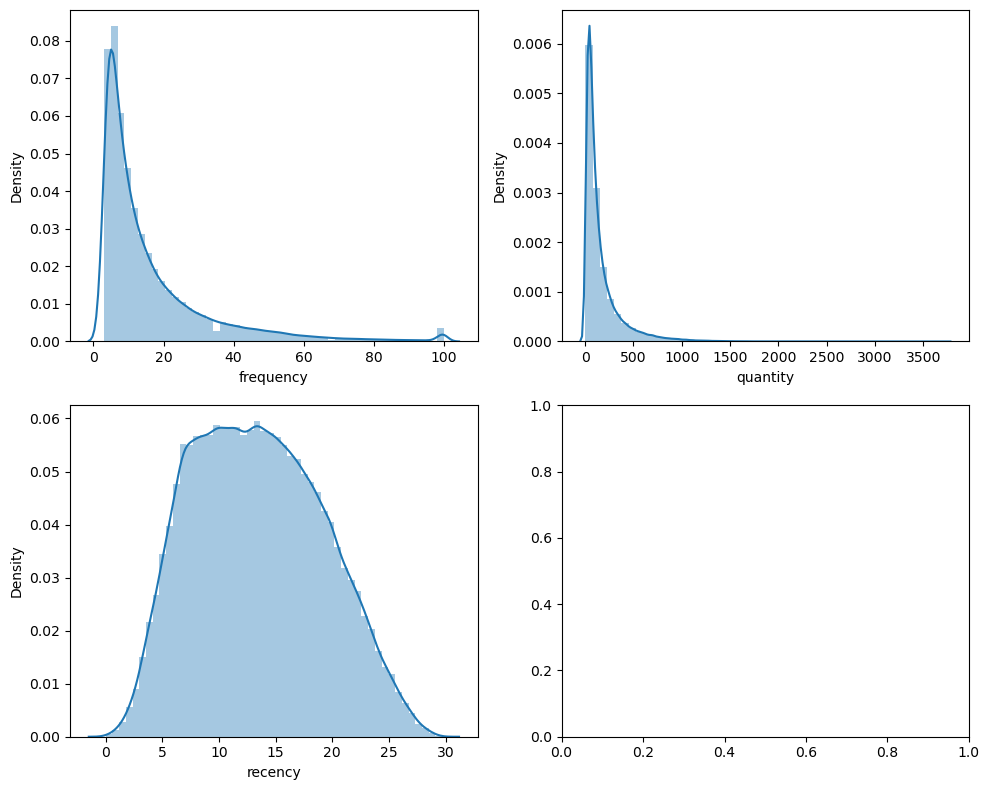

In [7]:
fig,ax = plt.subplots(2,2,figsize =(10,8))
sns.distplot(users['frequency'],ax =ax[0,0])
sns.distplot(users['quantity'],ax =ax[0,1])
sns.distplot(users['recency'],ax =ax[1,0])
plt.tight_layout()


In [159]:
r_labels = range(4,0,-1)
f_labels = range(1,5)
m_labels = range(1, 5)
max_score = 10
quant_score = range(1, max_score + 1)
quant_split = [i / max_score for i in range(max_score + 1)]

quants_recency = users['recency'].quantile(quant_split)
quants_freq = users['frequency'].quantile(quant_split)
quants_quantity = users['quantity'].quantile(quant_split)



users['recency_score'] = pd.qcut(users['recency'], q = 5, labels=[5,4,3,2,1]).astype(int)
users['frequency_score'] = pd.qcut(users['frequency'], q = 5, labels=[1,2,3,4,5]).astype(int)
users['quantity_score'] = pd.qcut(users['quantity'], q = 5, labels=[1,2,3,4,5]).astype(int)

users['recency_score'].fillna(1, inplace=True)
users['frequency_score'].fillna(1, inplace=True)
users['quantity_score'].fillna(1, inplace=True)


users.groupby('recency_score').agg(count=('user_id', 'count'),
    min_recency=('recency', min),
    max_recency=('recency', max),
    std_recency=('recency', 'std'),    
    avg_recency=('recency', 'mean'))



,count,min_recency,max_recency,std_recency,avg_recency
recency_score,,,,,
1,41242,18.745455,29.702970,2.231173,21.757319
2,41242,14.881890,18.745223,1.108755,16.740572
3,41241,11.424797,14.881356,0.995430,13.152189
4,41242,7.956522,11.424658,1.000274,9.703375
5,41242,0.000000,7.956439,1.557951,5.792484


In [160]:
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206209 entries, 0 to 206208
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          206209 non-null  int64  
 1   quantity         206209 non-null  int64  
 2   recency          206209 non-null  float64
 3   frequency        206209 non-null  int64  
 4   recency_score    206209 non-null  int32  
 5   frequency_score  206209 non-null  int32  
 6   quantity_score   206209 non-null  int32  
dtypes: float64(1), int32(3), int64(3)
memory usage: 8.7 MB


In [161]:
groupby_results = prior__data.groupby('user_id').agg(organic_perf = ('organic','mean') ,
                                          gluten_perf = ('gluten','mean') ,
                                          vegetarian_perf = ('vegetarian','mean'), 
                                          dairy_perf = ('dairy free','mean'), 
                                          vegan_perf = ('vegan','mean') )


In [167]:
users = users.merge(groupby_results, on = 'user_id', how = 'inner')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206209 entries, 0 to 206208
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          206209 non-null  int64  
 1   quantity         206209 non-null  int64  
 2   recency          206209 non-null  float64
 3   frequency        206209 non-null  int64  
 4   recency_score    206209 non-null  int32  
 5   frequency_score  206209 non-null  int32  
 6   quantity_score   206209 non-null  int32  
 7   organic_perf     206209 non-null  float64
 8   gluten_perf      206209 non-null  float64
 9   vegetarian_perf  206209 non-null  float64
 10  dairy_perf       206209 non-null  float64
 11  vegan_perf       206209 non-null  float64
dtypes: float64(6), int32(3), int64(3)
memory usage: 16.5 MB


In [168]:
users.head(4)

,user_id,quantity,recency,frequency,recency_score,frequency_score,quantity_score,organic_perf,gluten_perf,vegetarian_perf,dairy_perf,vegan_perf
0,1,70,17.828571,11,2,3,3,0.257143,0.000000,0.0,0.0,0.0
1,2,226,16.973451,15,2,4,4,0.247788,0.030973,0.0,0.0,0.0
2,3,88,10.181818,12,4,3,3,0.340909,0.022727,0.0,0.0,0.0
3,4,18,11.944444,5,3,1,1,0.111111,0.000000,0.0,0.0,0.0


In [172]:
categories = prior__data.groupby(['user_id','department'])['product_id'].size().reset_index(name ='pcount')


In [173]:
subcategories = prior__data.groupby(['user_id','aisle','department'])['product_id'].size().reset_index(name ='sub_acount')


In [174]:
categories.head()
categories_encoded = pd.get_dummies(categories,columns=['department'],prefix='', prefix_sep = '' )

categories_encoded = pd.concat([categories['user_id'], categories_encoded, categories['pcount']], axis=1)
categories_encoded.head()

,user_id,user_id,pcount,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,...,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,pcount
0,1,1,15,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,15
1,1,1,4,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,4
2,1,1,17,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,17
3,1,1,3,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,3
4,1,1,1,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,1


In [165]:
subcategories[subcategories['user_id'] == 15].head(10)

,user_id,aisle,department,sub_acount
352,15,candy chocolate,snacks,8
353,15,cleaning products,household,1
354,15,juice nectars,beverages,11
355,15,mint gum,snacks,1
356,15,nuts seeds dried fruit,snacks,18
357,15,popcorn jerky,snacks,15
358,15,soft drinks,beverages,9
359,15,trail mix snack mix,snacks,9


<Axes: >

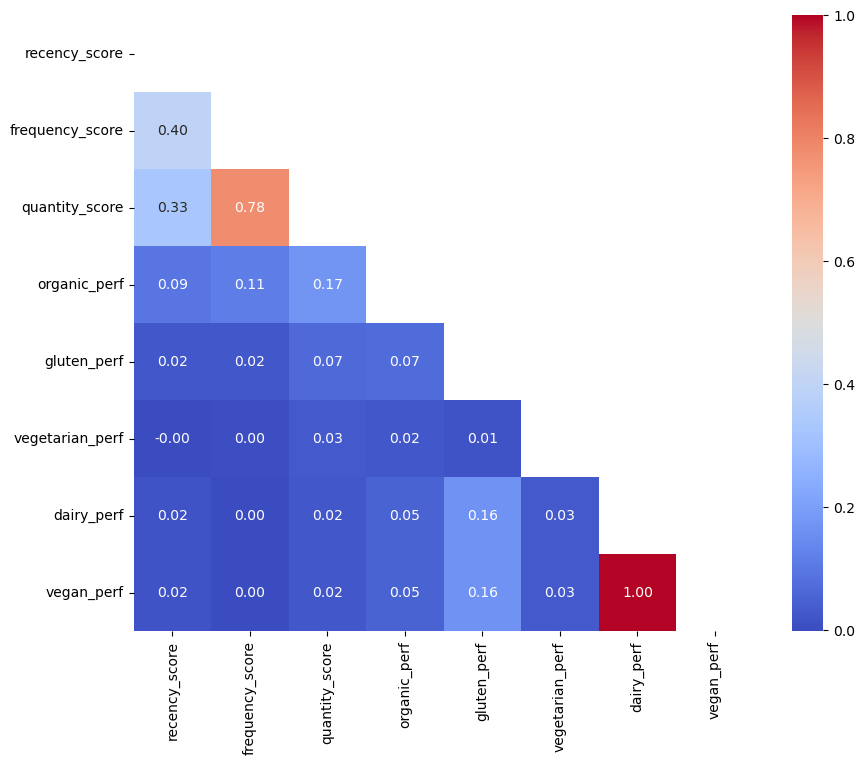

In [178]:
user_corr = users.drop(columns =['user_id','recency','frequency','quantity'])
correlation_matrix = user_corr.corr()
mask = np.triu(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)


In [175]:
user_corr.index.name = 'user_id'
user_corr.reset

AttributeError: 'DataFrame' object has no attribute 'reset'

[2.66918666e-01 2.51168311e-01 1.26750974e-01 1.22488198e-01
 1.13003020e-01 9.30468243e-02 2.66240063e-02 9.59590988e-34]


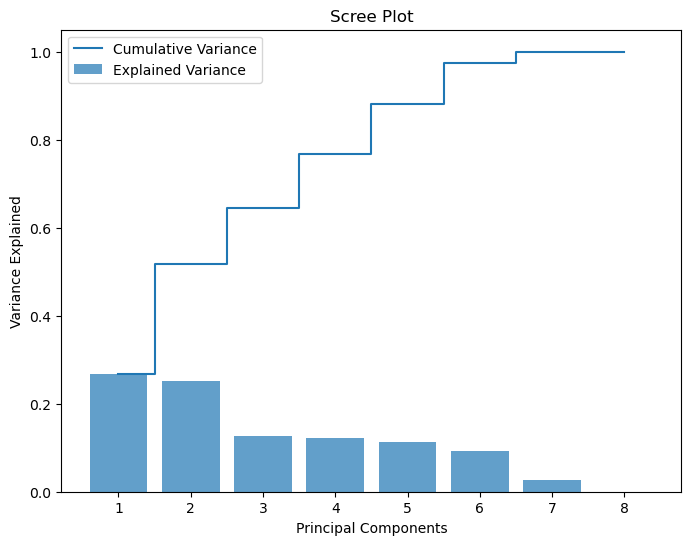

In [177]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_corr)
scaled_data_df = pd.DataFrame(scaled_data)
pca = PCA()
principal_components = pca.fit_transform(scaled_data)

# Scree Plot
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(explained_variance)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Explained Variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Variance')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.legend()
plt.show()

In [180]:
%%time
#fit_predict method to both fit the K-Means clusterer and obtain the cluster assignments 

# Set a random seed for reproducibility
random_seed = 42

# Create a K-Means clusterer with the chosen number of clusters
kmeans = KMeans(n_clusters=3, random_state=random_seed)
#cluster_labels = kmeans.fit_predict(scaled_data)
kmeans.fit(scaled_data_df)
cluster_labels = kmeans.labels_

df_new = scaled_data_df.assign(Cluster = cluster_labels)
#transformed = kmeans.fit_tranform(scaled_data)

C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


CPU times: total: 11.2 s
Wall time: 1.68 s


<timed exec>:13: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.


CPU times: total: 2 s
Wall time: 597 ms


Text(0.5, 1.0, 'Clustering using K-Means Algorithm')

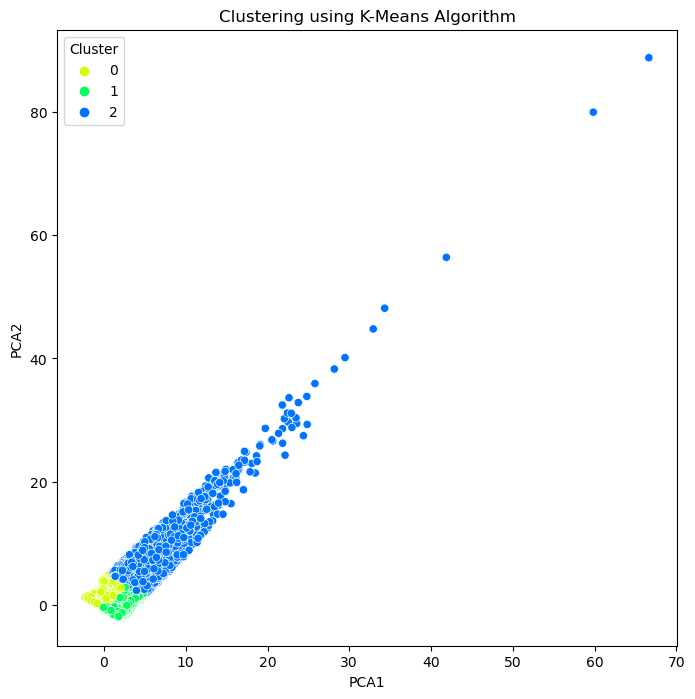

In [181]:
%%time

pca = PCA(n_components = 2)
principal_components = pca.fit_transform(scaled_data_df)

pca_df = pd.DataFrame(data = principal_components, columns=['PCA1','PCA2'])
pca_df['Cluster'] = cluster_labels
#pca_df_kmeans = pd.concat([pca_df,pd.DataFrame({'cluster' : cluster_labels})],axis = 1)

# Create a custom color palette based on the number of clusters
cluster_palette = sns.color_palette("hsv", 4)


plt.figure(figsize =(8,8))
ax = sns.scatterplot(x = 'PCA1',y='PCA2',hue='Cluster', data = pca_df,palette=cluster_palette)
plt.title("Clustering using K-Means Algorithm")

In [130]:
# Lets do reverse engineering... from the scaled data lets inverse to original data
# so that we can use original format or scale for better interpretation
#cluster_centers = pd.DataFrame(data = clusterer.cluster_centers_)#,columns = [features.columns])
cluster_centers_org = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_info = pd.DataFrame(cluster_centers_org, columns=user_corr.columns)

index_start = 1
labels  = pd.DataFrame({'Cluster': kmeans.labels_})
labels.index = range(index_start, index_start + len(kmeans.labels_))
original_data_with_clusters = pd.concat([user_corr, labels], axis=1)
'

In [131]:
original_data_with_clusters

,recency_score,frequency_score,quantity_score,organic_perf,gluten_perf,vegetarian_perf,dairy_perf,vegan_perf,Cluster
user_id,,,,,,,,,
0,2.0,3.0,3.0,0.257143,0.000000,0.000000,0.000000,0.000000,NaN
1,2.0,4.0,4.0,0.247788,0.030973,0.000000,0.000000,0.000000,0.0
2,4.0,3.0,3.0,0.340909,0.022727,0.000000,0.000000,0.000000,1.0
3,3.0,1.0,1.0,0.111111,0.000000,0.000000,0.000000,0.000000,1.0
4,4.0,1.0,2.0,0.500000,0.021739,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
206205,5.0,5.0,5.0,0.305263,0.052632,0.000000,0.003509,0.003509,0.0
206206,3.0,4.0,4.0,0.529148,0.000000,0.017937,0.000000,0.000000,1.0
206207,5.0,5.0,5.0,0.438700,0.004431,0.000000,0.000000,0.000000,1.0


In [186]:
df_new.columns =['recency_score', 
                                   'frequency_score',
                                   'quantity_score',
                                   'organic_perf',
                                   'gluten_perf', 
                                   'vegetarian_perf',
                                  'dairy_perf',
                                  'vegan_perf','Cluster']
#df_new.head(4)
#df_new.index.name  = 'user_id'
merged_df = pd.concat([df_new,users], axis =1)
merged_df = merged_df[['user_id', 'Cluster','recency_score', 
                                   'frequency_score',
                                   'quantity_score',
                                   'organic_perf',
                                   'gluten_perf', 
                                   'vegetarian_perf',
                                  'dairy_perf',
                                  'vegan_perf']]

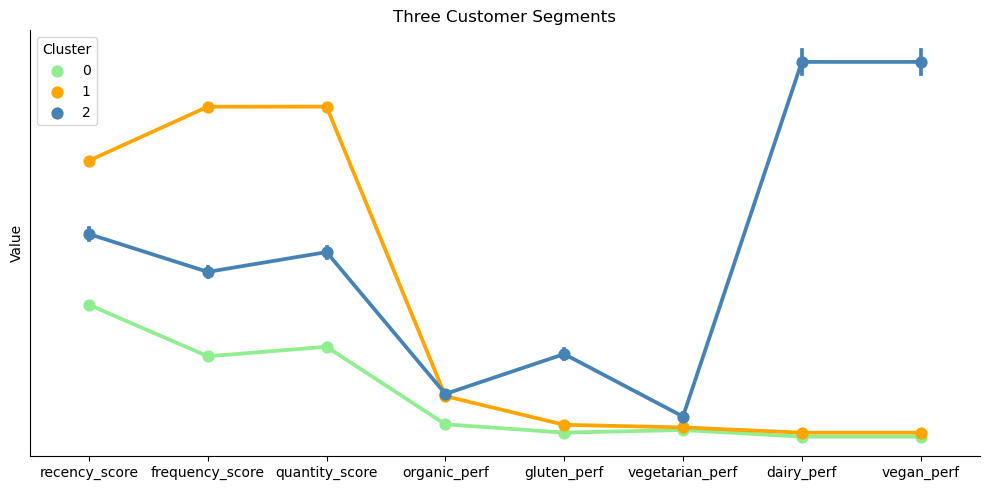

In [188]:
""" Let's visualize how different customer segments as per clusters ib various metrics
(attributes) with the dataset. """
cluster_melt = pd.melt(merged_df.reset_index(),
                       id_vars=['user_id', 'Cluster'],
                       value_vars=['recency_score', 
                                   'frequency_score',
                                   'quantity_score',
                                   'organic_perf',
                                   'gluten_perf', 
                                   'vegetarian_perf',
                                  'dairy_perf',
                                  'vegan_perf'],
                       var_name='Metric',
                       value_name='Value')
# Create snake plot
palette = ['lightgreen', 'orange', 'steelblue','black','purple','green','red','yellow']
plt.figure(figsize=(10,5))
sns.pointplot(x='Metric', y='Value', data=cluster_melt, hue='Cluster', 
              palette=palette)
plt.xlabel('')
plt.ylabel('Value')
plt.yticks([])
plt.title('Three Customer Segments')
sns.despine()
plt.tight_layout()
plt.savefig('snake_plot.png', dpi=300, pad_inches=2.0)
plt.show();


In [133]:
#features_train_set['order_on_peak'] = np.where(features_train_set['order_dow'] <= 1, 1, 0)
#features_train_set['peak_time'] = np.where((features_train_set['order_hour_of_day'] >= 10) & (features_train_set['order_hour_of_day'] <= 16) , 1, 0)

In [145]:
#scaler = StandardScaler()
#selected_columns = ['num_orders','peakday_rate','median_hour','peaktime_rate','mean_lag','mean_products']
#selected_features = features_test_set[selected_columns]
#features_test_set_scaled = scaler.fit_transform(selected_features)
#features_test_set.columns

In [137]:
#train_peakday_rate = round(features_train_set.groupby('user_id')['order_on_peak'].mean(),2)
#train_median_hour = round(features_train_set.groupby('user_id')['order_hour_of_day'].median(),0)
#train_peaktime_rate = round(features_train_set.groupby('user_id')['peak_time'].mean(),2)
#train_mean_lag = round(features_train_set.groupby('user_id')['days_since_prior_order'].mean(),2)
#train_mean_products = round(features_train_set.groupby('user_id')['num_products'].mean(),2)
#features_train_set = pd.concat([train_orders_counts,train_peakday_rate,train_median_hour,train_peaktime_rate,train_mean_lag,train_mean_products],axis = 1)#.reset_index()
#features_train_set.columns = ['num_orders','peakday_rate','median_hour','peaktime_rate','mean_lag','mean_products']


In [124]:
#train_orders_counts = features_train_set.groupby('user_id')['order_id'].count().reset_index(name='num_orders')

#train_orders_counts.reset_index(drop=True, inplace=True)
#train_orders_counts.set_index('user_id', inplace=True)
#train_orders_counts.info()

In [138]:
original_data_with_clusters[original_data_with_clusters['Cluster'] == 1].head(10)

,num_orders,peakday_rate,median_hour,peaktime_rate,mean_lag,mean_products,Cluster
user_id,,,,,,,
1,11,0.27,8.0,0.36,17.27,6.36,1
2,15,0.40,10.0,0.80,15.20,15.07,1
4,5,0.00,13.0,1.00,11.00,3.60,1
7,21,0.52,13.0,0.57,9.95,10.24,1
8,4,0.50,4.0,0.25,17.50,16.75,1
9,4,0.50,13.0,0.75,16.50,24.50,1
11,7,0.14,11.0,0.86,17.57,13.43,1
12,5,0.40,9.0,0.20,20.00,14.80,1
14,14,0.21,8.0,0.14,19.71,15.79,1


In [ ]:
for c in cluster_df.drop(['Cluster'],axis=1):
    grid= sns.FacetGrid(cluster_df, col='Cluster')
    grid= grid.map(plt.hist, c)
plt.show()

In [128]:
kmeans.cluster_centers_

array([[ 1.79226273, -0.08228413, -0.23622895, -0.02456024, -1.13994052,
         0.05657469],
       [-0.36883374,  0.02207475, -0.44387734,  0.42135201,  0.25610402,
        -0.01247243],
       [-0.32856486,  0.00374074,  1.12995108, -0.91402653,  0.16151147,
        -0.00854062]])

In [90]:
feature_scaled

array([[-0.31368362, -0.40118315, -2.15903305, -0.95389857,  0.74513572,
        -0.62054891],
       [-0.07361924,  0.21282914, -1.3865816 ,  0.96700651,  0.36603953,
         0.87067423],
       [-0.25366752,  1.48808544,  0.93077273,  0.00655397, -0.38849009,
        -0.45447699],
       ...,
       [-0.01360315,  0.11836571, -0.61413016,  0.1811817 ,  0.0437162 ,
         0.677209  ],
       [ 1.96692792, -0.21225629,  0.54454701,  0.48678024, -1.08258409,
         0.65666402],
       [-0.13363534, -0.30671972,  0.15832129,  0.92334958,  0.72132775,
        -0.0333049 ]])

In [77]:
feature_scaled

,num_orders,peakday_rate,median_hour,peaktime_rate,mean_lag,mean_products
0,-0.313684,-0.401183,-2.159033,-0.953899,0.745136,-0.620549
1,-0.073619,0.212829,-1.386582,0.967007,0.366040,0.870674
2,-0.253668,1.488085,0.930773,0.006554,-0.388490,-0.454477
3,-0.673780,-1.676439,-0.227904,1.840145,-0.403141,-1.093083
4,-0.673780,1.157463,0.930773,0.093868,-0.732790,-0.134318
...,...,...,...,...,...,...
206204,-0.733796,-0.495647,0.930773,1.840145,-0.128434,0.473471
206205,3.047218,0.165597,1.316998,-0.822928,-1.736388,-0.981798
206206,-0.013603,0.118366,-0.614130,0.181182,0.043716,0.677209
206207,1.966928,-0.212256,0.544547,0.486780,-1.082584,0.656664


In [102]:
cluster_centers_original

array([[46.06962747,  0.33753134, 12.97770636,  0.57286516,  6.9785344 ,
        10.31405785],
       [10.07755357,  0.35961925, 12.4411377 ,  0.67504394, 14.60176207,
         9.91184327],
       [10.75190157,  0.35572148, 16.5156786 ,  0.36908911, 14.08192338,
         9.93463572]])

In [119]:
labels  = pd.DataFrame({'Cluster': kmeans.labels_})
labels.index = range(1, 1+len(kmeans.labels_))

print(labels)

        Cluster
1             1
2             1
3             2
4             1
5             2
...         ...
206205        1
206206        0
206207        1
206208        0
206209        1

[206209 rows x 1 columns]


In [108]:
cluster_info

,num_orders,peakday_rate,median_hour,peaktime_rate,mean_lag,mean_products
0,46.069627,0.337531,12.977706,0.572865,6.978534,10.314058
1,10.077554,0.359619,12.441138,0.675044,14.601762,9.911843
2,10.751902,0.355721,16.515679,0.369089,14.081923,9.934636


In [64]:
features.head(4)

,num_orders,peakday_rate,median_hour,peaktime_rate,mean_lag,mean_products
user_id,,,,,,
1,11,0.27,8.0,0.36,17.27,6.36
2,15,0.40,10.0,0.80,15.20,15.07
3,12,0.67,16.0,0.58,11.08,7.33
4,5,0.00,13.0,1.00,11.00,3.60


In [100]:
feature_scaled

array([[-0.31368362, -0.40118315, -2.15903305, -0.95389857,  0.74513572,
        -0.62054891],
       [-0.07361924,  0.21282914, -1.3865816 ,  0.96700651,  0.36603953,
         0.87067423],
       [-0.25366752,  1.48808544,  0.93077273,  0.00655397, -0.38849009,
        -0.45447699],
       ...,
       [-0.01360315,  0.11836571, -0.61413016,  0.1811817 ,  0.0437162 ,
         0.677209  ],
       [ 1.96692792, -0.21225629,  0.54454701,  0.48678024, -1.08258409,
         0.65666402],
       [-0.13363534, -0.30671972,  0.15832129,  0.92334958,  0.72132775,
        -0.0333049 ]])

In [122]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206209 entries, 1 to 206209
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_orders     206209 non-null  int64  
 1   peakday_rate   206209 non-null  float64
 2   median_hour    206209 non-null  float64
 3   peaktime_rate  206209 non-null  float64
 4   mean_lag       206209 non-null  float64
 5   mean_products  206209 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 19.1 MB


In [134]:
#cluster_df = cluster_df.dropna()
cluster_centers.info()
cluster_centers.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       3 non-null      float64
 1   1       3 non-null      float64
 2   2       3 non-null      float64
 3   3       3 non-null      float64
 4   4       3 non-null      float64
 5   5       3 non-null      float64
dtypes: float64(6)
memory usage: 276.0 bytes


0    0
1    0
2    0
3    0
4    0
5    0
dtype: int64

In [136]:
cluster_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 206210 entries, 1 to 0
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_orders     206209 non-null  float64
 1   peakday_rate   206209 non-null  float64
 2   median_hour    206209 non-null  float64
 3   peaktime_rate  206209 non-null  float64
 4   mean_lag       206209 non-null  float64
 5   mean_products  206209 non-null  float64
 6   Cluster        206209 non-null  float64
dtypes: float64(7)
memory usage: 12.6 MB


In [77]:
feature_original = scaler.inverse_transform (feature_scaled)
feature_original = pd.DataFrame(feature_original, columns = [features.columns])
feature_original
print(feature_original)

       num_orders peakday_rate median_hour peaktime_rate   mean_lag  \
0       16.060210     0.239549    4.667025      0.199291  26.573057   
1       22.429155     0.371026    7.855990      1.015095  19.701631   
2       19.511300     1.050322   17.422885      0.575816  13.624590   
3        2.939911    -0.417834   12.639437      1.454373  13.465713   
4       -1.283882     0.677805   19.017367      0.408471  11.479752   
...           ...          ...         ...           ...        ...   
206204  -6.729298    -0.417834   15.828402      1.454373  18.093003   
206205  52.064424     0.436764   19.017367      0.178373  -0.992085   
206206  24.956716     0.414851   11.044955      0.659488  18.311458   
206207  46.142192     0.261462   15.828402      0.805914   6.097797   
206208  21.026395     0.261462   12.639437      0.973259  23.693413   

       mean_products  
0           6.371794  
1          16.967258  
2           9.048411  
3           0.278904  
4          11.917734  
...      

In [93]:
cluster_subset = cluster_df.drop(['peakday_rate','median_hour','peaktime_rate'],axis = 1)
cluster_subset.columns = ['Number of Orders','Avg. Lag Between Orders','Avg. # Products Per Order','Cluster']
cluster_subset.head(4)

,Number of Orders,Avg. Lag Between Orders,Avg. # Products Per Order,Cluster
user_id,,,,
1,10.0,17.60,5.90,2.0
2,14.0,14.14,13.93,0.0
3,12.0,11.08,7.33,2.0
4,5.0,11.00,3.60,0.0


In [95]:
X = cluster_df.drop(['Cluster'] , axis = 1)
y = cluster_df[['Cluster']]
X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3)
model= DecisionTreeClassifier(criterion="entropy")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

ValueError: Input y contains NaN.

In [96]:
cluster_df.isnull().sum()

num_orders       1
peakday_rate     1
median_hour      1
peaktime_rate    1
mean_lag         1
mean_products    1
Cluster          1
dtype: int64

In [197]:
features_test_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131209 entries, 0 to 131208
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   order_id                131209 non-null  int64  
 1   num_products            131209 non-null  int64  
 2   user_id                 131209 non-null  int64  
 3   eval_set                131209 non-null  object 
 4   order_number            131209 non-null  int64  
 5   order_dow               131209 non-null  int64  
 6   order_hour_of_day       131209 non-null  int64  
 7   days_since_prior_order  131209 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 8.0+ MB


In [189]:
null_indices = cluster_df.index[cluster_df.isnull().any(axis=1)]
print(null_indices)


Index([206209, 0], dtype='int64')


In [34]:

y_pred_testdata = model.predict(features_test_set_scaled)

C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [35]:
y_pred_testdata

array([0., 0., 0., ..., 0., 0., 0.])

In [36]:
feature_with_clusters = list(zip(feature_original, cluster_labels))


In [37]:
%%time

# Create a K-Means clusterer with the chosen number of clusters
kmeans = KMeans(n_clusters=3, random_state=0)

# Fit the K-Means clusterer to your scaled features
#clusterer = kmeans.fit(feature_scaled)

# Get the cluster assignments for each data point
#cluster_labels = clusterer.labels_
feature_scaled_c = feature_scaled.assign(Cluster = cluster_labels)

model = TSNE( random_state=1)
transformed = tsne.fit_transform(feature_scaled)
#reduced_features = tsne.fit_transform(feature_scaled)

plt.title('Flattened Graph of 6 Clusters')
sns.scatterplot(x=transformed[:,0], y=transformed[:,1], 
                    hue=cluster_labels, style=cluster_labels, palette="Set1")
    


NameError: name 'tsne' is not defined

In [58]:
%%time
kmeans = KMeans(n_clusters=3, random_state=0)

feature_fewer= features.drop(['median_hour','peakday_rate','peaktime_rate'], axis = 1)

scaler = StandardScaler()
feature_few_scalar = scaler.fit_transform(feature_fewer)

feature_few_scalar = pd.DataFrame(feature_few_scalar)
# Fit the K-Means clusterer to your scaled features
clusterer = kmeans.fit(feature_few_scalar)

# Get the cluster assignments for each data point
cluster_labels = clusterer.labels_
feature_few_scalar_c = feature_few_scalar.assign(Cluster = cluster_labels)


C:\Users\Pallavi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


CPU times: total: 10.1 s
Wall time: 1.54 s


In [29]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 206209 entries, 1 to 206209
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num_orders     206209 non-null  int64  
 1   peakday_rate   206209 non-null  float64
 2   median_hour    206209 non-null  float64
 3   peaktime_rate  206209 non-null  float64
 4   mean_lag       206209 non-null  float64
 5   mean_products  206209 non-null  float64
dtypes: float64(5), int64(1)
memory usage: 19.1 MB


In [218]:
%%time

from sklearn.manifold import TSNE
# Create a K-Means clusterer with the chosen number of clusters
#kmeans = KMeans(n_clusters=6, random_state=0)

#feature_scaled_few = feature_scaled.drop(['median_hour','peakday_rate','peaktime_rate'], axis = 1)
# Fit the K-Means clusterer to your scaled features
#clusterer = kmeans.fit(feature_scaled_few)

# Get the cluster assignments for each data point
#cluster_labels = clusterer.labels_
#feature_scaled_few_c = feature_scaled_few.assign(Cluster = cluster_labels)

model = TSNE( random_state=1)
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)

transformed = tsne.fit_transform(feature_few_scalar)
#reduced_features = tsne.fit_transform(feature_scaled)

plt.title('Flattened Graph of 3 Clusters')
sns.scatterplot(x=transformed[:,0], y=transformed[:,1], 
                    hue=cluster_labels, style=cluster_labels, palette="Set1")
    


NameError: name 'feature_few_scalar' is not defined

In [30]:
feature_fewer= features.drop(['median_hour','peakday_rate','peaktime_rate'], axis = 1)
features.head(3)

,num_orders,peakday_rate,median_hour,peaktime_rate,mean_lag,mean_products
user_id,,,,,,
1,2.302585,0.30,8.0,0.40,17.60,5.90
2,2.639057,0.36,10.0,0.79,14.14,13.93
3,2.484907,0.67,16.0,0.58,11.08,7.33


In [31]:
cluster_df = pd.DataFrame(feature_few_scalar_c)
cluster_df.index = feature_fewer.index
cluster_df.columns = ['Number of Orders', 'Avg. Lag Between Orders', 
                      'Avg. # Products Per Order', 'Cluster']
cluster_df.head()



NameError: name 'feature_few_scalar_c' is not defined

In [32]:

# Working M part
#quantity = prior_orders_data.groupby('order_id').size().reset_index(name='product_cnt')
#full_orders = pd.merge(orders,quantity,  how ='left', on = 'order_id')
quantity_items = prior_orders_data.groupby('user_id')['product_id'].count().reset_index(name='quantity')
# R part

user_transaction = prior_orders_data.groupby('user_id')['days_since_prior_order'].mean().reset_index(name = 'recency')

# F part 

user_fpart = prior_orders_data.groupby('user_id')['order_number'].max().reset_index()
user_fpart.rename(columns={'order_number': 'frequency'}, inplace=True)

In [33]:
merge1 = pd.merge(quantity_items, user_transaction, on = 'user_id' ,how ='left')
users =  pd.merge(merge1,user_fpart, on  = 'user_id', how = 'left')
users.head(5)

,user_id,quantity,recency,frequency
0,1,70,17.828571,11
1,2,226,16.973451,15
2,3,88,10.181818,12
3,4,18,11.944444,5
4,5,46,9.369565,5


C:\Users\Pallavi\AppData\Local\Temp\ipykernel_2968\3864142754.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(users['frequency'],ax =ax[0,0])
C:\Users\Pallavi\AppData\Local\Temp\ipykernel_2968\3864142754.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(users['quantity'],ax =ax[0,1])
C:\Us

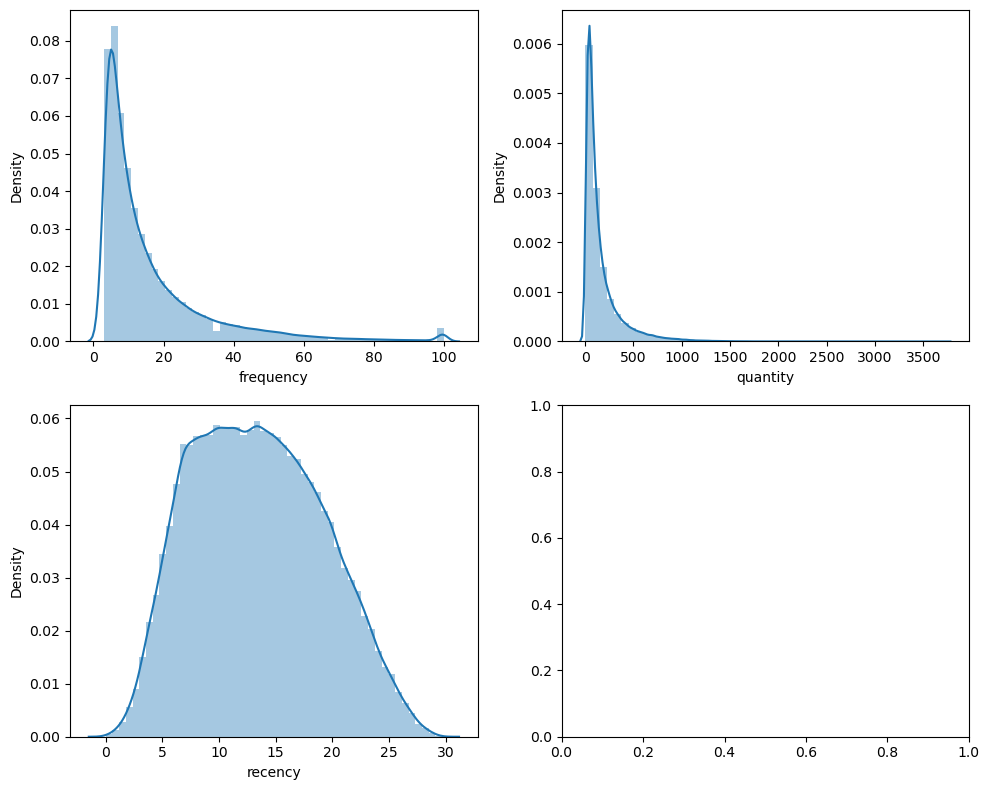

In [22]:
fig,ax = plt.subplots(2,2,figsize =(10,8))
sns.distplot(users['frequency'],ax =ax[0,0])
sns.distplot(users['quantity'],ax =ax[0,1])
sns.distplot(users['recency'],ax =ax[1,0])
plt.tight_layout()

In [34]:
r_labels = range(4,0,-1)
f_labels = range(1,5)
m_labels = range(1, 5)
max_score = 10
quant_score = range(1, max_score + 1)
quant_split = [i / max_score for i in range(max_score + 1)]

quants_recency = users['recency'].quantile(quant_split)
quants_freq = users['frequency'].quantile(quant_split)
quants_quantity = users['quantity'].quantile(quant_split)



users['recency_score'] = pd.qcut(users['recency'], q = 5, labels=[5,4,3,2,1]).astype(int)
users['frequency_score'] = pd.qcut(users['frequency'], q = 5, labels=[1,2,3,4,5]).astype(int)
users['quantity_score'] = pd.qcut(users['quantity'], q = 5, labels=[1,2,3,4,5]).astype(int)

users['recency_score'].fillna(1, inplace=True)
users['frequency_score'].fillna(1, inplace=True)
users['quantity_score'].fillna(1, inplace=True)

In [35]:
users.groupby('recency_score').agg(count=('user_id', 'count'),
    min_recency=('recency', min),
    max_recency=('recency', max),
    std_recency=('recency', 'std'),    
    avg_recency=('recency', 'mean'))

,count,min_recency,max_recency,std_recency,avg_recency
recency_score,,,,,
1,41242,18.745455,29.702970,2.231173,21.757319
2,41242,14.881890,18.745223,1.108755,16.740572
3,41241,11.424797,14.881356,0.995430,13.152189
4,41242,7.956522,11.424658,1.000274,9.703375
5,41242,0.000000,7.956439,1.557951,5.792484


In [36]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206209 entries, 0 to 206208
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          206209 non-null  int64  
 1   quantity         206209 non-null  int64  
 2   recency          206209 non-null  float64
 3   frequency        206209 non-null  int64  
 4   recency_score    206209 non-null  int32  
 5   frequency_score  206209 non-null  int32  
 6   quantity_score   206209 non-null  int32  
dtypes: float64(1), int32(3), int64(3)
memory usage: 8.7 MB


In [37]:
groupby_results = prior_orders_data.groupby('user_id').agg(organic_perf = ('organic','mean') ,
                                          gluten_perf = ('gluten','mean') ,
                                          vegetarian_perf = ('vegetarian','mean'), 
                                          dairy_perf = ('dairy free','mean'), 
                                          vegan_perf = ('vegan','mean') )

In [38]:
users = users.merge(groupby_results, on = 'user_id', how = 'inner')

In [39]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206209 entries, 0 to 206208
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   user_id          206209 non-null  int64  
 1   quantity         206209 non-null  int64  
 2   recency          206209 non-null  float64
 3   frequency        206209 non-null  int64  
 4   recency_score    206209 non-null  int32  
 5   frequency_score  206209 non-null  int32  
 6   quantity_score   206209 non-null  int32  
 7   organic_perf     206209 non-null  float64
 8   gluten_perf      206209 non-null  float64
 9   vegetarian_perf  206209 non-null  float64
 10  dairy_perf       206209 non-null  float64
 11  vegan_perf       206209 non-null  float64
dtypes: float64(6), int32(3), int64(3)
memory usage: 16.5 MB


In [40]:
users.head(5)

,user_id,quantity,recency,frequency,recency_score,frequency_score,quantity_score,organic_perf,gluten_perf,vegetarian_perf,dairy_perf,vegan_perf
0,1,70,17.828571,11,2,3,3,0.257143,0.000000,0.0,0.0,0.0
1,2,226,16.973451,15,2,4,4,0.247788,0.030973,0.0,0.0,0.0
2,3,88,10.181818,12,4,3,3,0.340909,0.022727,0.0,0.0,0.0
3,4,18,11.944444,5,3,1,1,0.111111,0.000000,0.0,0.0,0.0
4,5,46,9.369565,5,4,1,2,0.500000,0.021739,0.0,0.0,0.0


In [41]:
categories = prior_orders_data.groupby(['user_id','department'])['product_id'].size().reset_index(name ='pcount')
#users.merge(categories,on = 'user_id' , how = 'inner')

In [42]:
subcategories = prior_orders_data.groupby(['user_id','aisle','department'])['product_id'].size().reset_index(name ='sub_acount')

In [43]:
categories.head()
categories_encoded = pd.get_dummies(categories,columns=['department'],prefix='', prefix_sep = '' )

categories_encoded = pd.concat([categories['user_id'], categories_encoded, categories['pcount']], axis=1)
categories_encoded.head()

,user_id,user_id,pcount,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,...,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,pcount
0,1,1,15,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,15
1,1,1,4,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,4
2,1,1,17,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,17
3,1,1,3,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,3
4,1,1,1,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,1


In [44]:
 subcategories[subcategories['user_id'] == 15].head(10)

,user_id,aisle,department,sub_acount
352,15,candy chocolate,snacks,8
353,15,cleaning products,household,1
354,15,juice nectars,beverages,11
355,15,mint gum,snacks,1
356,15,nuts seeds dried fruit,snacks,18
357,15,popcorn jerky,snacks,15
358,15,soft drinks,beverages,9
359,15,trail mix snack mix,snacks,9


<Axes: >

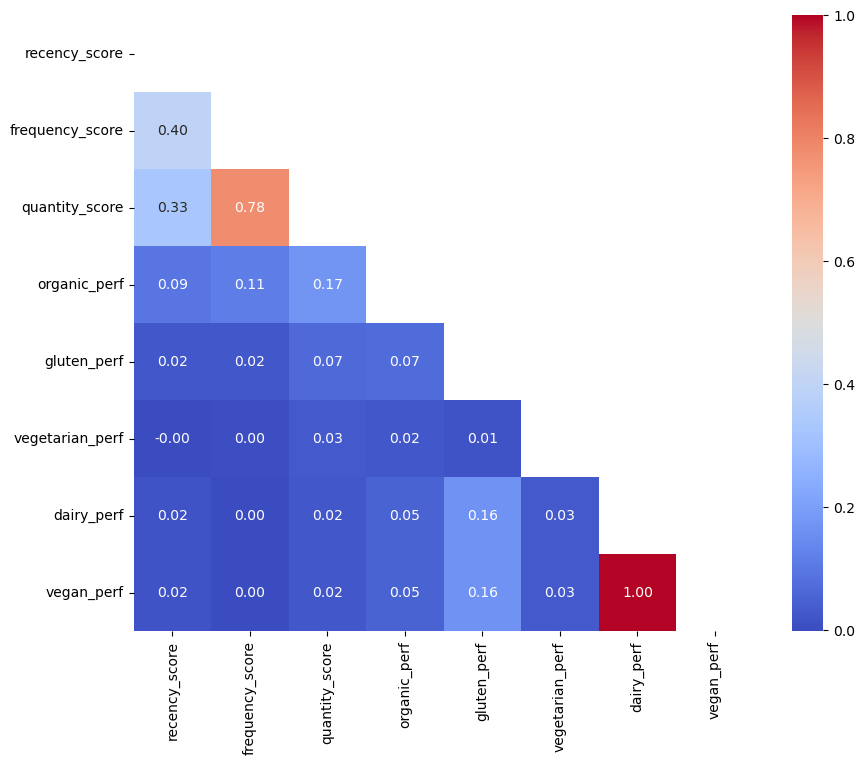

In [79]:
import numpy as np

user_corr = users.drop(columns =['user_id','recency','frequency','quantity'])
correlation_matrix = user_corr.corr()
mask = np.triu(correlation_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)


In [45]:
from sklearn.decomposition import PCA
    
scaler = StandardScaler()
scaled_data = scaler.fit_transform(user_corr)

pca = PCA()
principal_components = pca.fit_transform(scaled_data)

# Scree Plot
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(explained_variance)

plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, align='center', label='Explained Variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Variance')
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.title('Scree Plot')
plt.legend()
plt.show()

NameError: name 'user_corr' is not defined

In [ ]:
contributions = pca.components_

# Create a DataFrame to display the contributions
contributions_df = pd.DataFrame(contributions, columns=user_corr.columns)

# Display the top 10 contributors to the first principal component (PC1)
top_contributors_pc1 = contributions_df.iloc[0].sort_values(ascending=False).head(10)
print(top_contributors_pc1)

In [113]:
prior_orders_data


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,organic,gluten,vegetarian,dairy free,vegan,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1,49302,1,1,Bulgarian Yogurt,120,16,0,0,0,0,0,yogurt,dairy eggs,112108,train,4,4,10,9.0
1,1,49683,4,0,Cucumber Kirby,83,4,0,0,0,0,0,fresh vegetables,produce,112108,train,4,4,10,9.0
2,1,13176,6,0,Bag of Organic Bananas,24,4,1,0,0,0,0,fresh fruits,produce,112108,train,4,4,10,9.0
3,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15,0,0,0,0,0,canned meat seafood,canned goods,112108,train,4,4,10,9.0
4,1,10246,3,0,Organic Celery Hearts,83,4,1,0,0,0,0,fresh vegetables,produce,112108,train,4,4,10,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33819101,3421083,11352,7,0,Organic Mini Sandwich Crackers Peanut Butter,78,19,1,0,0,0,0,crackers,snacks,25247,prior,24,2,6,21.0
33819102,3421083,5020,10,1,Organic Sweet & Salty Peanut Pretzel Granola ...,3,19,1,0,0,0,0,energy granola bars,snacks,25247,prior,24,2,6,21.0
33819103,3421083,21162,3,0,Organic Mixed Berry Yogurt & Fruit Snack,92,18,1,0,0,0,0,baby food formula,babies,25247,prior,24,2,6,21.0
33819104,3421083,39678,6,1,Free & Clear Natural Dishwasher Detergent,74,17,0,0,0,0,0,dish detergents,household,25247,prior,24,2,6,21.0


In [211]:
feature_scaled

,num_orders,peakday_rate,median_hour,peaktime_rate,mean_lag,mean_products,Cluster_label
0,-0.249493,-2.111747,-0.755826,0.891953,-0.690977,3,4
1,0.024542,-1.356303,0.893522,0.248368,0.678499,2,0
2,1.440388,0.910031,0.005412,-0.320815,-0.447098,2,5
3,-1.619667,-0.223136,1.781633,-0.335695,-1.083230,3,3
4,0.663956,1.287753,-0.332916,-0.521702,-0.119651,1,2
...,...,...,...,...,...,...,...
206204,-1.619667,0.532309,1.781633,0.097702,0.122522,3,3
206205,0.161559,1.287753,-0.798117,-1.689828,-0.972376,0,1
206206,0.115887,-0.600858,0.174576,0.118163,0.680204,0,1
206207,-0.203821,0.532309,0.470612,-1.025782,0.659739,0,1


In [175]:
features['Cluster_label'] = feature_scaled['Cluster_label']

KeyError: 'Cluster_label'

In [162]:
%%time

user_clusters = kmeans.predict(feature_scaled)
plt.figure(figsize = (10,8))
sns.scatterplot(x = reduced_features[:,0],
               y = reduced_features[:,1], alpha = 0.8, hue = aisle_clusters, palette = 'Dark2')
     


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Cluster_label


In [ ]:
%%time

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

inertia = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(feature_scaled)  # X is your data
    inertia.append(kmeans.inertia_)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [159]:
aisle.info()

NameError: name 'aisle' is not defined

customer behavior in terms of recency, frequency, and monetary values. RFM analysis is usually performed on data related to customer transactions.